# Example 13: Single Cell Killing Analysis

We define the T cell in contact that the cancer cell first reach CDI value 0.5 as the killer cell.

From this we store the killer T cell track ID and examine the accumulated contacts compare the result against cell kinematics.

This is a very complex running task and standalone python script is provided in [./example_13.py](./example_13.py) for background process.

In [1]:
import pandas as pd
import numpy as np
from cyto.postprocessing.sparse_to_sparse import *
import matplotlib.pyplot as plt
import seaborn as sns
from dask.distributed import Client
import dask.dataframe as dd

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 251.55 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43621,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 251.55 GiB
Comm: tcp://127.0.0.1:44547,Total threads: 4
Dashboard: http://127.0.0.1:43423/status,Memory: 31.44 GiB
Nanny: tcp://127.0.0.1:46011,


## Data Loading

In [3]:
TCELL_DATA_PATH = "/mnt/Data/UTSE/2023_11_24_1G4PrimCD8_Nyeso1_HCT116_CTFR_100nM_ICAM5ug_framerate10sec_flow_0p1mlperh_analysis/plots/contact_analysis/Cyto/Tcell/track_tcell_merge_int_contact_ddf.csv"

CANCER_DATA_PATH = "/mnt/Data/UTSE/2023_11_24_1G4PrimCD8_Nyeso1_HCT116_CTFR_100nM_ICAM5ug_framerate10sec_flow_0p1mlperh_analysis/plots/contact_analysis/Cyto/Cancer/track_cancer_merge_int_contact_ddf.csv"

In [4]:
tcell_ddf = dd.read_csv(TCELL_DATA_PATH)
cancer_ddf = dd.read_csv(CANCER_DATA_PATH)

## Compute the Table for Necessary Values

In [5]:
tcell_ddf, tcell_ctfr_lp, tcell_ctfr_up = intensity_norm_percentile(tcell_ddf,channel="ctfr_mean", percentile=1)
tcell_ddf, tcell_pi_lp, tcell_pi_up = intensity_norm_percentile(tcell_ddf,channel="pi_mean", percentile=1)

In [ ]:
tcell_ddf.to_csv("./tmp/tcell.csv",index=False)

In [5]:
cancer_ddf, cancer_gfp_lp, cancer_gfp_up = intensity_norm_percentile(cancer_ddf,channel="gfp_mean", percentile=1)
cancer_ddf, cancer_pi_lp, cancer_pi_up = intensity_norm_percentile(cancer_ddf,channel="pi_mean", percentile=1)

In [ ]:
cancer_ddf = calculate_cdi(cancer_ddf, viability_col="gfp_mean_norm", death_col="pi_mean_norm")
cancer_ddf

In [ ]:
cancer_ddf = compute_savgol_filter(cancer_ddf, track_id_col='track_id', frame_col='frame', value_col='CDI', window_length=500, polyorder=3)
cancer_ddf

In [ ]:

cancer_ddf.to_csv("./tmp/cancer.csv",index=False)

In [3]:
tcell_ddf = dd.read_csv("./tmp/tcell.csv/*.part")
cancer_ddf = dd.read_csv("./tmp/cancer.csv/*.part")

In [4]:
tcell_df = tcell_ddf.compute()
cancer_df = cancer_ddf.compute()

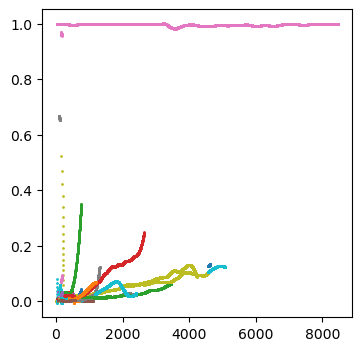

In [46]:
fig, axs = plt.subplots(1,1,figsize=(4,4))

for i in range(200):
    axs.scatter(cancer_df[cancer_df["track_id"]==i]["frame"],cancer_df[cancer_df["track_id"]==i]["CDI_smoothed"],s=1)

## Match CDI of Cancer Cells to Back Trace T Cells in Contact

In [57]:
def identify_killer_t_cell(df):
    df_filtered = df.groupby('track_id').filter(lambda x: ((x['CDI_smoothed'] > 0) & (x['CDI_smoothed'] < 0.5)).any())
    # Step 2: Filter for rows where 'value' is greater than or equal to 0.5
    df_filtered = df_filtered[df_filtered['CDI_smoothed'] >= 0.5]

    # Step 3: Group by 'track_id' and get the first occurrence of 'frame' for each group
    first_frame = df_filtered.sort_values(by=['frame']).groupby('track_id').first().reset_index()

    # Step 4: Extract the 'track_id' and 'frame' columns
    result = first_frame[['track_id', 'frame', 'contacting cell labels']]

    return result

killer_t_cells = identify_killer_t_cell(cancer_df)
# killer_t_cells = killer_t_cells.compute()
killer_t_cells

,track_id,frame,contacting cell labels
0,158,139,[111785 111892 113022 113279 113513]
1,495,224,[120827]
2,528,346,[50357]
3,577,406,[13195]
4,610,6362,[172517 174841 175097]
...,...,...,...
15111,208478,8188,[121686 121925 121960 124903]
15112,208493,8374,[237578 238969]
15113,208506,8446,[203085 203259 204026]
15114,208514,8422,[95977 97157 97573 97670 99474]


In [58]:
# save the killer t cell df
killer_t_cells.to_csv("./tmp/killer_t_cells.csv",index=False)

In [59]:
killer_t_cells = dd.read_csv("./tmp/killer_t_cells.csv")
killer_t_cells = killer_t_cells.compute()
killer_t_cells

,track_id,frame,contacting cell labels
0,158,139,[111785 111892 113022 113279 113513]
1,495,224,[120827]
2,528,346,[50357]
3,577,406,[13195]
4,610,6362,[172517 174841 175097]
...,...,...,...
15111,208478,8188,[121686 121925 121960 124903]
15112,208493,8374,[237578 238969]
15113,208506,8446,[203085 203259 204026]
15114,208514,8422,[95977 97157 97573 97670 99474]


Text(0.5, 1.0, 'Cell ID: 3437')

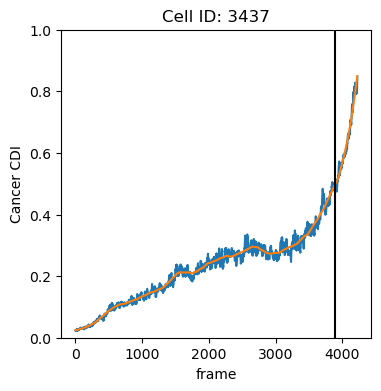

In [124]:
killer_id = 40 #FAST:10,38; SLOW: 20,40

track_id = killer_t_cells["track_id"][killer_id]

track = cancer_df[cancer_df["track_id"]==track_id]
track = track.sort_values(by=["frame"])

fig, axs = plt.subplots(1,1,figsize=(4,4))

axs.plot(track["frame"],track["CDI"])
axs.plot(track["frame"],track["CDI_smoothed"])
axs.axvline(killer_t_cells["frame"][killer_id], c="k", label="Killing Event")
axs.set_xlabel("frame")
axs.set_ylabel("Cancer CDI")
axs.set_ylim(0,1)
axs.set_title("Cell ID: {}".format(track_id))

In [68]:
killing_count = killer_t_cells.groupby("frame")["track_id"].count()
killing_count

frame
0       7
1       2
5       1
14      1
42      1
       ..
8461    1
8462    1
8463    1
8464    1
8465    1
Name: track_id, Length: 5626, dtype: int64

Text(0.5, 0, 'Frame')

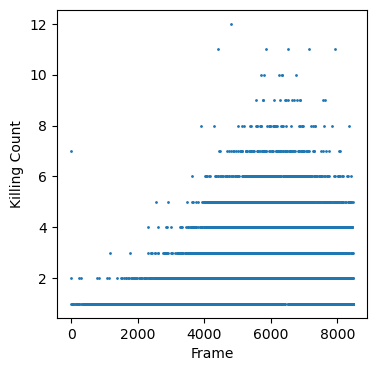

In [69]:
# plot the killing time
fig, axs = plt.subplots(1,1,figsize=(4,4))

axs.scatter(killing_count.index, killing_count, s=1)
axs.set_ylabel("Killing Count")
axs.set_xlabel("Frame")

### Put Killing Event Tag to The T Cell Dataframe

In [78]:
contacts = {
    "frame": [],
    "label": [],
    "kill": []
}

for idx, row in killer_t_cells.iterrows():
    tcells = row["contacting cell labels"]
    tcells = tcells.strip('[]')

    for j in tcells.split():
        contacts["frame"].append(row["frame"])
        contacts["label"].append(int(j))        
        contacts["kill"].append(True)

contacts = pd.DataFrame.from_dict(contacts)
contacts

,frame,label,kill
0,139,111785,True
1,139,111892,True
2,139,113022,True
3,139,113279,True
4,139,113513,True
...,...,...,...
39493,8422,97157,True
39494,8422,97573,True
39495,8422,97670,True
39496,8422,99474,True


In [81]:
t_cell_counts = tcell_ddf.groupby("frame")["track_id"].count().cumsum()
t_cell_counts = t_cell_counts.compute()
t_cell_counts

frame
0           3834
1           7659
2          11472
3          15303
4          19128
          ...   
8474    23582647
8475    23586261
8476    23589882
8477    23593513
8478    23595270
Name: track_id, Length: 8479, dtype: int64

In [95]:
# offset the label id by time
contacts['label'] = contacts.apply(lambda x: x["label"] + t_cell_counts[x["frame"]], axis=1)
contacts

,frame,label,kill,label_time_offset
0,139,383207,True,383207
1,139,383314,True,383314
2,139,384444,True,384444
3,139,384701,True,384701
4,139,384935,True,384935
...,...,...,...,...
39493,8422,23491218,True,23491218
39494,8422,23491634,True,23491634
39495,8422,23491731,True,23491731
39496,8422,23493535,True,23493535


In [96]:
tcell_with_kill = dd.merge(tcell_ddf,contacts[["kill","label"]], on=["label"], how="left")
tcell_with_kill = tcell_with_kill.compute()
tcell_with_kill['kill'] = tcell_with_kill['kill'].fillna(False)
tcell_with_kill

,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,...,mean tracked cell size,ctfr_mean,ctfr_median,ctfr_sd,closest cell dist,contact,contacting cell labels,ctfr_mean_norm,pi_mean_norm,kill
0,23506300,858.538462,236.400000,233,854,8,11,236.400000,858.538462,233.0,...,70.276939,176.907692,170.613281,46.081356,1.278615,True,[125845 126247 128438],0.046086,0.663729,False
1,23538897,431.114583,745.031250,740,425,10,13,745.031250,431.114583,740.0,...,96.497207,197.677083,181.884766,87.373909,2.257658,True,[154477 155484 156668],0.065297,0.187571,False
2,23567508,793.029557,991.211823,982,785,18,16,991.211823,793.029557,982.0,...,91.668539,283.083744,236.503906,132.560346,4.948832,True,[178131 178237],0.144295,0.921509,False
3,23622464,609.587629,245.000000,240,605,11,11,245.000000,609.587629,240.0,...,90.530528,133.309278,110.714844,9.515733,0.417839,True,[224965],0.005759,0.216690,False
4,23639053,702.212389,738.796460,733,696,11,14,738.796460,702.212389,733.0,...,96.565789,151.637168,124.521484,16.637985,2.199979,True,[237891],0.022711,0.590100,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149309,25536488,393.279070,69.976744,67,389,7,9,69.976744,393.279070,67.0,...,48.211568,242.000000,228.626953,73.172334,2.582023,True,[122932],0.106294,0.013658,False
149310,25550106,14.000000,196.000000,194,12,5,5,196.000000,14.000000,194.0,...,31.588235,232.000000,255.275391,37.811374,5.537556,True,[134641 134642],0.097044,0.016048,False
149311,25578560,335.098039,216.294118,213,330,7,10,216.294118,335.098039,213.0,...,51.037634,136.529412,134.843750,10.462032,2.111787,True,[157757 160683],0.008737,0.155278,False
149312,25585404,519.011236,707.191011,702,515,13,9,707.191011,519.011236,702.0,...,73.827160,368.393258,315.595703,195.640476,5.555626,True,[164636 165154],0.223203,0.027446,False


## Plotting

In [102]:
tcell_killing = tcell_with_kill[tcell_with_kill["kill"]]
tcell_killing

,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,...,mean tracked cell size,ctfr_mean,ctfr_median,ctfr_sd,closest cell dist,contact,contacting cell labels,ctfr_mean_norm,pi_mean_norm,kill
1014,15797544,345.060606,861.863636,858,341,9,9,861.863636,345.060606,858.0,...,60.157895,137.393939,151.865234,10.468824,0.452191,True,[145105 146397],0.009537,0.133913,True
2026,15028702,115.810345,277.586207,273,112,10,8,277.586207,115.810345,273.0,...,61.544066,135.241379,152.421875,9.454063,0.055889,True,[1862 3013],0.007546,0.140038,True
2479,22220044,537.735294,104.000000,101,535,7,6,104.000000,537.735294,101.0,...,41.684637,283.941176,243.453125,123.457008,9.365353,True,[160096],0.145088,0.014782,True
3110,1740480,121.564103,524.205128,521,119,7,7,524.205128,121.564103,521.0,...,40.373016,246.410256,220.816406,116.353300,6.238581,True,[206291 206574],0.110373,0.000472,True
4006,22161197,863.983333,710.116667,706,860,9,9,710.116667,863.983333,706.0,...,55.126876,137.016667,145.615234,9.441150,1.214161,True,[112526 112527],0.009188,0.199961,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145593,6760697,647.188889,852.544444,848,642,10,11,852.544444,647.188889,848.0,...,87.681818,486.633333,358.326172,318.966747,7.986900,True,[50158 50476],0.332571,0.009504,True
145625,9237829,674.155556,506.377778,502,671,9,8,506.377778,674.155556,502.0,...,94.200000,316.200000,260.250000,148.513636,4.017539,True,[84223 86713],0.174926,0.038985,True
146002,16077805,308.000000,202.000000,199,304,7,9,202.000000,308.000000,199.0,...,52.076336,132.816327,118.806641,7.873144,1.989818,True,[116203 117292],0.005303,0.050516,True
146743,4943714,581.190476,966.642857,964,578,6,8,966.642857,581.190476,964.0,...,59.349793,404.333333,322.970703,241.110203,3.508371,True,[277620 279114],0.256446,0.004818,True


In [104]:
tcell_killing.columns

Index(['label', 'y', 'x', 'bbox_xstart', 'bbox_ystart', 'bbox_xsize',
       'bbox_ysize', 'i', 'j', 'bbox_istart', 'bbox_jstart', 'bbox_isize',
       'bbox_jsize', 'size', 'elongation', 'flatness', 'roundness',
       'feret_diameter', 'feret_radius', 'perimeter', 'mass', 'pi_mean',
       'pi_median', 'pi_sd', 'frame', 'channel', 'alive', 'track_id', 'id',
       'dist_from_ultrack', 'tracked frames', 'tracked length',
       'mean tracked cell size', 'ctfr_mean', 'ctfr_median', 'ctfr_sd',
       'closest cell dist', 'contact', 'contacting cell labels',
       'ctfr_mean_norm', 'pi_mean_norm', 'kill'],
      dtype='object')

In [109]:
killers = len(tcell_with_kill[tcell_with_kill["kill"]]["track_id"].unique())
non_killers = len(tcell_with_kill[~tcell_with_kill["kill"]]["track_id"].unique())

print("killers count:", killers)
print("non-killers count:", non_killers)
print("killer ratio: {:.2f}%".format(killers/(killers+non_killers)*100))


killers count: 22422
non-killers count: 178462
killer ratio: 11.16%


Median Killing Count: 66.00
Lower 10% Killing Count: 22.00
Upper 10% Killing Count: 273.00


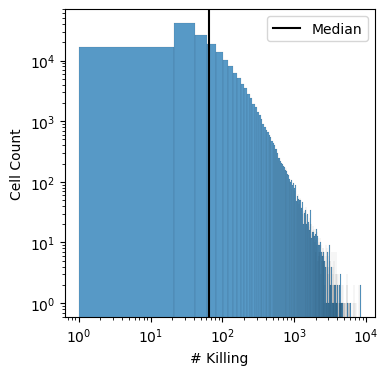

In [144]:
kill_count = tcell_with_kill.groupby("track_id")["kill"].count()

fig, axs = plt.subplots(1,1,figsize=(4,4))
sns.histplot(kill_count,binwidth=20)
plt.xlabel("# Killing")
plt.ylabel("Cell Count")
plt.yscale("log")
plt.xscale("log")
axs.axvline(np.median(kill_count),c="k",label="Median")
axs.legend()

print("Median Killing Count: {:.2f}".format(np.median(kill_count)))
print("Lower 10% Killing Count: {:.2f}".format(np.percentile(kill_count,10)))
print("Upper 10% Killing Count: {:.2f}".format(np.percentile(kill_count,90)))